# Looking through N-Grams as Factors
### (Started July 2, 2019)

## Introduction
After seeing the potentially strong results from filtering the articles by "phase" then by a second keyword, it became clear that there could be some other interesting groupings of words.

The intuition is that there are likely to be certain groups of words that could result in statistically significant risk-adjusted returns.

The high-level approach will be:
1. Reduce the words in the corpus of text as much as possible. The key here is to remove as many irrelevant words.
2. For each set of n-grams:
    * Filter the article Data Frame using the words in the n-gram
    * Get the Return metrics for the filtered articles
3. Calculate and sort by the metrics

## Table of Contents 

1. ["Imports, Settings and Data Loading"](#1)
2. ["Text Cleaning and Feature Reduction"](#2)
3. ["Build N-Gram Functionality](#3)

<a id="1"></a>
## Imports, Settings and Data Loading

Note: All of this section came from the previous notebook.

In [1]:
# Imports

# Standard Libraries
from itertools import combinations

# Numerical Libraries
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Local Package Libraries
import sys
sys.path.append("../..")

from src.data.make_dataset import *
from src.features.general_helper_functions import *
from src.features.text_cleaning import *

In [2]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

In [3]:
_, watchlist_raw, stock_prices_raw = get_raw_data()

*(Added the cleaning and formatting functions to make_dataset.py - July 2, 2019)*

In [164]:
article_raw = clean_and_open_business_wire_data_01(None)
article_df = article_raw.copy()
article_df.reset_index(inplace=True)
article_df.time = pd.to_datetime(article_df.time)

# Watchlist
watchlist_df = clean_and_format_watchlist(watchlist_raw, article_df.ticker.unique())


# Stock Prices
prices_df = clean_and_format_prices(stock_prices_raw, article_df.ticker.unique())

# Return Window
return_window = compute_return_window(article_df, prices_df, n_window=30)

return_window.sort_index().head()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,...,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29,R_30
0,0.016568,-0.017357,0.019329,0.012229,0.010651,0.008679,0.011045,-0.042998,0.002761,0.022880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.010794,-0.035081,-0.065921,-0.015420,-0.030840,-0.023130,0.000771,0.007710,-0.052043,-0.040093,...,-0.064765,-0.020046,-0.000386,0.026214,-0.008096,0.002313,NaN,NaN,NaN,NaN
3,0.013173,0.006587,0.001162,-0.045719,-0.008136,0.005037,-0.005812,-0.030221,-0.061217,-0.010461,...,-0.034870,0.001162,-0.005812,-0.007361,-0.009299,-0.006974,-0.060054,-0.015110,0.004649,0.031383
4,0.040000,0.050588,0.012157,0.025490,0.018824,0.013333,-0.034118,0.003922,0.017255,0.006275,...,-0.043529,-0.005882,0.010588,-0.023137,0.013333,0.006275,0.004706,0.002745,0.005098,-0.048627


This return window is of the format: holding it for n days (R_n)

## Text Cleaning and Feature Reduction

Note: The first block is also from the previous Notebook. Should probably add these to src.

*(Added to src: nlp_functions.py - July 2, 2019)*

In [5]:
def token_in_text(text, token):
    for token_ in text.split(" "):
        if token_ == token:
            return True
    return False

def calculate_word_frequency(word_list, df):
    d = {word: sum([1 if token_in_text(article, word) else 0 for article in df.title.values])/df.shape[0] for word in word_list}
    
    return pd.Series(d, index = d.keys()).sort_values(ascending=False)

def get_list_of_words(articles, cut_off):    
    combined_titles = " ".join(articles.title.values.tolist())

    set_of_words = list(set(combined_titles.split(" ")))
    
    set_of_words = [word for word in set_of_words if len(word) > 3]

    word_frequency = calculate_word_frequency(set_of_words, articles)
    set_of_words = word_frequency.loc[word_frequency > cut_off].index
    return set_of_words

In [165]:
article_df = clean_text(article_df, "title")

list_of_words = get_list_of_words(article_df, cut_off=0.01)

print(len(list_of_words))

147


Now can go through the article titles and filter out all words that are not in the list_of_words.

In [57]:
def keep_sublist_words(text, list_of_words):
    return " ".join([word for word in text.split(" ") if word in list_of_words])

In [166]:
article_df.title = article_df.title.apply(keep_sublist_words, args=(list_of_words,))

Can drop the columns "ticker" and "article" as they won't be needed. 

Further, it will be useful to have a column for each word with a value of True or False if the word exists in the title or not.

In [167]:
article_df = article_df.drop(["ticker", "article"], axis=1)

In [168]:
for word in list_of_words:
    article_df[word] = article_df.title.apply(token_in_text, args=(word,))
    
article_df.shape

(8433, 150)

In [169]:
article_df.head()

,index,time,title,market,researchandmarkets,global,research,pipeline,announce,report,...,name,public,north,delivery,american,gene,strategy,receive,stage,administration
0,0,2019-06-04,pharmaceutical present annual global healthcar...,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2019-05-18,pharmaceutical present phase result treatment ...,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,2,2019-05-15,grow company award,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,2019-05-07,pharmaceutical present america health care con...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,2019-05-02,disease pipeline review insight researchandmar...,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Let's take a quick look at how many words are left in each article title

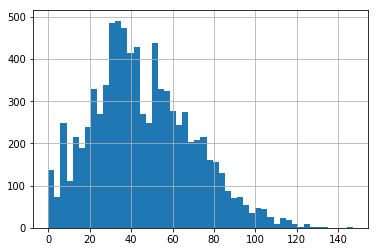

In [170]:
article_df.title.apply(len).hist(bins=50)

As can be seen, there are quite a lot of rows that contain very few words. This could mean that the cut-off is too strong, or it could mean that those articles would lead to being statistically insignificant.

<a id="3"></a>

## Build N-Gram

In [63]:
def get_n_gram(words, n):
    return combinations(words, n)

def get_ngram_articles(articles, ngram_tuple):
    temp_articles = articles.copy()
    for word in ngram_tuple:
        temp_articles = temp_articles.loc[temp_articles[word]]
    return temp_articles.index.tolist()

def get_dict_ngram_articles(articles, list_of_words):
    ngram = get_n_gram(list_of_words, 2)
    return {word_tuple: get_ngram_articles(article_df, word_tuple) for word_tuple in ngram}

In [171]:
%%time
dict_linking_ngram_to_indexes = get_dict_ngram_articles(article_df, list_of_words)


print(len(dict_linking_ngram_to_indexes))

10731
Wall time: 58 s


<a id="4"></a>

## Iterate and Calculate Metrics per N-Gram

For each n-gram will need to collect the stock returns for our window, then calculate the return metrics.

In [65]:
# Original function is from Notebook 02 and converted to work with n-grams

def get_return_details_per_word(article_df, return_df, word_list, holding_period, cut_off=0.05):
    set_of_ngrams = get_n_gram(word_list, 2)
    
    res_dict = {}
    for ngram in set_of_ngrams:
        event_id_list = get_ngram_articles(article_df, ngram)
        #print(event_id_list)
        returns = return_df["R_{}".format(holding_period - 1)]iloc[event_id_list].dropna()
        
        # note will use the string of the ngram for now as I need to learn more about
        # multi-indexing with pandas
        res_dict[str(ngram)] = [
            np.mean(returns), 
            np.std(returns), 
            skew(returns.values), 
            kurtosis(returns.values),
            returns.shape[0]/article_df.shape[0]
        ]
    
    cols = ["return", "dev", "skew", "kurt", "freq_occurance"]
    
    return pd.DataFrame(res_dict, index=cols).T

In [66]:
res_df = get_return_details_per_word(article_df, 
                                     return_window, 
                                     list_of_words, 
                                     holding_period=20, 
                                     cut_off=0.05)

In [172]:
def sharpe_ratio(row, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * row["return"] - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * row["dev"])
    return num / den

In [18]:
res_df["sharpe_ratio"] = res_df.apply(sharpe_ratio, args=(20, 0.025,), axis=1)
res_df.sort_values("sharpe_ratio", ascending=False, inplace=True)

print("Top 10 Sharpe Ratios:")
print(res_df.head(10))

print("Bottom 10 Sharpe Ratios:")
print(res_df.tail(10))

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Top 10 Sharpe Ratios:
                                 return  dev  skew  kurt  freq_occurance  \
('increase', 'biotechnology')  0.143888  0.0   0.0  -3.0        0.000119   
('appointment', 'strategy')    0.379430  0.0   0.0  -3.0        0.000119   
('cell', 'life')               0.222821  0.0   0.0  -3.0        0.000119   
('cagr', 'service')            0.330714  0.0   0.0  -3.0        0.000119   
('announce', 'vendor')         0.043609  0.0   0.0  -3.0        0.000119   
('system', 'oncology')         0.525436  0.0   0.0  -3.0        0.000119   
('system', 'science')          0.027810  0.0   0.0  -3.0        0.000119   
('cell', 'launch')             0.525436  0.0   0.0  -3.0        0.000119   
('medicine', 'player')         0.143888  0.0   0.0  -3.0        0.000119   
('system', 'medicine')         0.525436  0.0   0.0  -3.0        0.000119   

                               sharpe_ratio  
('increase', 'biotechnology')           inf  
('appointment', 'strategy')             inf  
('c

Note: I also need to have a cutoff for the n-grams! The issue here is that the frequency occurred is basically zero for a lot of these results. will use a similar functionality as with the individual words.

In [173]:
# Adding frequency cut-off for n-grams

def get_return_details_per_word(article_df, return_df, word_list, holding_period, cut_off=0.05):
    set_of_ngrams = get_n_gram(word_list, 2)
    
    res_dict = {}
    for ngram in set_of_ngrams:
        event_id_list = get_ngram_articles(article_df, ngram)
        
        size_prior_to_nan_removal = len(event_id_list)
        returns = return_df["R_{}".format(holding_period)].loc[event_id_list].dropna()
        num_removed = size_prior_to_nan_removal - returns.shape[0]
        
        freq = returns.shape[0]/article_df.shape[0]
        if freq >= cut_off:
        
            res_dict[ngram] = [
                np.mean(returns), 
                np.std(returns), 
                skew(returns.values), 
                kurtosis(returns.values),
                freq,
                num_removed,
                len(event_id_list)
            ]
    
    cols = ["return", "dev", "skew", "kurt", "freq_occurance", "samples_removed", "num_events"]
    
    return pd.DataFrame(res_dict, index=cols).T

In [174]:
res_df = get_return_details_per_word(article_df, 
                                     return_window, 
                                     list_of_words, 
                                     holding_period=20, 
                                     cut_off=0.05)

In [175]:
res_df["sharpe_ratio"] = res_df.apply(sharpe_ratio, args=(20, 0.025,), axis=1)
res_df.sort_values("sharpe_ratio", ascending=False, inplace=True)

In [176]:
print("Top 10 Sharpe Ratios:")
res_df.head(10)

Top 10 Sharpe Ratios:


return       dev      skew       kurt  freq_occurance  \
market   pipeline  0.043962  0.221925  1.037349   3.557509        0.059528   
research pipeline  0.043551  0.224875  1.038737   3.586414        0.054903   
market   report    0.031086  0.184769  1.316686  11.995089        0.057631   
         research  0.032940  0.204792  1.763978   9.204895        0.122258   
research review    0.034321  0.219468  1.006716   3.829497        0.053836   
market   review    0.033215  0.217157  0.997950   3.872826        0.056208   
global   research  0.023731  0.198898  2.410869  14.912735        0.060951   
market   analysis  0.019372  0.170803  1.120898   5.942855        0.074588   
result   quarter   0.020404  0.182595  0.985700   4.779130        0.062611   
market   forecast  0.016849  0.163643  2.199176  17.477891        0.091782   

                   samples_removed  num_events  sharpe_ratio  
market   pipeline            220.0       722.0      0.671422  
research pipeline            216.0       679.0      0.656131  
market   report               95.0       581.0      0.559092  
         research            296.0      1327.0      0.536552  
research review              196.0       650.0      0.523014  
market   review              198.0       672.0      0.510501  
global   research             95.0       609.0      0.388115  
market   analysis            120.0       749.0      0.361359  
result   quarter              17.0       545.0      0.358089  
market   forecast            154.0       928.0      0.322444

In [177]:
print("Bottom 10 Sharpe Ratios:")
res_df.tail(10)

Bottom 10 Sharpe Ratios:


return       dev      skew  \
market             forecast            0.016849  0.163643  2.199176   
researchandmarkets forecast            0.012273  0.138209  0.468965   
market             global              0.014081  0.169975  1.587596   
global             forecast            0.012136  0.164758  2.432294   
                   analysis            0.011974  0.166632  1.153649   
market             researchandmarkets  0.008031  0.148527  1.050331   
researchandmarkets analysis            0.005281  0.150323  0.524592   
                   global              0.005173  0.150163  0.725704   
pipeline           review             -0.001451  0.204959  1.180535   
researchandmarkets pipeline           -0.014053  0.163994  1.349348   

                                            kurt  freq_occurance  \
market             forecast            17.477891        0.091782   
researchandmarkets forecast             2.503093        0.068422   
market             global              11.081017        0.183090   
global             forecast            20.672397        0.069133   
                   analysis             7.206677        0.053599   
market             researchandmarkets   6.869644        0.170758   
researchandmarkets analysis             2.423376        0.064153   
                   global               2.695939        0.130321   
pipeline           review               4.424953        0.076485   
researchandmarkets pipeline             5.959210        0.074707   

                                       samples_removed  num_events  \
market             forecast                      154.0       928.0   
researchandmarkets forecast                      127.0       704.0   
market             global                        266.0      1810.0   
global             forecast                      121.0       704.0   
                   analysis                       86.0       538.0   
market             researchandmarkets            237.0      1677.0   
researchandmarkets analysis                       91.0       632.0   
                   global                        183.0      1282.0   
pipeline           review                        209.0       854.0   
researchandmarkets pipeline                       30.0       660.0   

                                       sharpe_ratio  
market             forecast                0.322444  
researchandmarkets forecast                0.264257  
market             global                  0.252624  
global             forecast                0.218711  
                   analysis                0.212814  
market             researchandmarkets      0.144509  
researchandmarkets analysis                0.077850  
                   global                  0.075385  
pipeline           review                 -0.059495  
researchandmarkets pipeline               -0.347117

## Intermediate Summary

Similar to the previous notebook, these results seem to be oddly amazing.

A Sharpe Ratio of 2 and better is classified as really good, and the occurance of the n-grams of words is high enough that is seems to be significant.

A few notes:
* The high Sharpe Ratio events also have a low positive skew and a highly negative kurtosis. This could imply that there are a a few very large negative results. If trading, this could lend well to option trading where there is a convex pay-off structure.
* The main research issues in this will be similar to those in the previous notebook as I still have not collected any additional data.
* I notice also that in the top 10, there are quite a few ngrams containing the words "view", "review, "market". I wonder if there is a reason for this. I will take a manual peek at those titles to see what is happening there.

## Manual Checking

In [78]:
ngrams_top_10 = res_df.head(10).index.tolist()

print(ngrams_top_10)

[('research', 'review'), ('global', 'research'), ('research', 'pipeline'), ('market', 'review'), ('market', 'research'), ('market', 'pipeline'), ('result', 'quarter'), ('pipeline', 'review'), ('market', 'report'), ('global', 'analysis')]


In [79]:
a, b = ngrams_top_10[0]

article_sample = article_df.loc[article_df.title.str.contains(a and b)].sample(5)

for _, article in article_sample.iterrows():
    print(article.title, "\n")

global pipeline review research market 

syndrome pipeline review researchandmarkets 

research market pain therapeutic pipeline review company drug profile 

pipeline review research market 

pipeline review research market 



**FIXED**
There is a really fundamental issue here that needs to be fixed. 

When searching for key words the way that is done here, view is a substring of review. Anytime that the word review happens, view will also happen. This needs to be changed.

**Note** Look into phi coefficient for binary feature correlation

## Confirming Results

Because I am skeptical of such good results, I would like to go through the top results with a fine-tooth comb.

This next section will be done inefficiently to ensure that everything is working the way it is intended to. I'd like to keep the logic straightforward w/o any clever ideas.

**Pseudo-code:**

* For each ngram:
    * For each article containing the ngram:
        * Calculate the return metrics and append to dataframe

In [80]:
# functions
def article_has_ngram(article, ngram):
    tokenized = article.split(" ")
    for gram in ngram:
        if gram not in tokenized:
            return False
    return True

In [106]:
# settings
article_data = clean_and_open_business_wire_data_01(None)
article_data.time = pd.to_datetime(article_data.time)
article_data = clean_text(article_data, "title")

ngram = ngrams_top_10[0]

hold_period = 19
risk_free_rate = 0.025

In [107]:
articles_containing_ngram = article_data.loc[article_data.title.apply(article_has_ngram, args=(ngram,))]

In [108]:
articles_containing_ngram.shape

(650, 4)

In [160]:
articles_containing_ngram.sort_index().head()

,time,title,ticker,article
2,2016-08-31,global uterine leiomyoma uterine fibroid pip...,BSTC,dublin--(business wire)--research and markets...
2,2017-03-22,bronchospasm global clinical trial review h ...,AMPH,dublin--(business wire)--research and markets...
3,2016-10-24,huntingtin huntington disease protein htt ...,QURE,dublin--(business wire)--research and markets...
3,2016-05-04,cellulite global clinical trial review anal...,BSTC,dublin--(business wire)--research and markets...
4,2016-03-23,uterine leiomyoma uterine fibroid therapeuti...,BSTC,dublin--(business wire)--research and markets...


In [159]:
test_getprices = GetPrices(articles_containing_ngram, prices_df, 19).add_prices_to_frame().sort_index().head()

test_getprices.head()

,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,P_11,P_12,P_13,P_14,P_15,P_16,P_17,P_18,P_19
2,36.59,37.55,36.56,36.10,36.42,37.06,36.54,37.28,37.61,38.47,41.37,42.76,41.82,44.00,43.75,44.04,45.26,45.39,46.12,46.87
2,13.60,13.71,13.76,14.27,14.63,14.69,14.73,14.50,14.17,14.30,14.20,14.37,14.62,14.56,14.66,14.76,14.80,14.88,14.54,14.51
3,7.05,6.97,6.98,6.77,6.91,6.79,7.29,6.91,6.68,7.07,6.91,6.76,7.29,7.74,8.14,8.30,7.73,7.04,7.07,7.12
3,34.56,35.16,34.80,35.18,37.64,35.68,34.35,34.31,34.47,34.32,33.79,33.96,35.07,35.13,35.98,36.21,36.12,36.50,37.53,39.08
4,32.08,32.42,33.57,34.98,34.53,34.82,35.70,34.86,35.25,38.62,36.99,36.69,36.55,36.82,36.27,34.92,36.90,36.13,35.10,35.31


In [149]:
test_ret_window = compute_return_window(articles_containing_ngram, prices_df, hold_period)

In [150]:
test_ret_window.sort_index().head()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19
2,0.026237,-0.000820,-0.013392,-0.004646,0.012845,-0.001366,0.018858,0.027876,0.051380,0.130637,0.168625,0.142935,0.202514,0.195682,0.203608,0.236950,0.240503,0.260454,0.280951
2,0.008088,0.011765,0.049265,0.075735,0.080147,0.083088,0.066176,0.041912,0.051471,0.044118,0.056618,0.075000,0.070588,0.077941,0.085294,0.088235,0.094118,0.069118,0.066912
3,-0.011348,-0.009929,-0.039716,-0.019858,-0.036879,0.034043,-0.019858,-0.052482,0.002837,-0.019858,-0.041135,0.034043,0.097872,0.154610,0.177305,0.096454,-0.001418,0.002837,0.009929
3,0.017361,0.006944,0.017940,0.089120,0.032407,-0.006076,-0.007234,-0.002604,-0.006944,-0.022280,-0.017361,0.014757,0.016493,0.041088,0.047743,0.045139,0.056134,0.085938,0.130787
4,0.010599,0.046446,0.090399,0.076372,0.085411,0.112843,0.086658,0.098815,0.203865,0.153055,0.143703,0.139339,0.147756,0.130611,0.088529,0.150249,0.126247,0.094140,0.100686


In [146]:
res_list = []
ret_window_list = []

for ind, row in articles_containing_ngram.iloc[:20].iterrows():
    ticker = row.ticker
    date = row.time
        
    if date in prices_df.index:
        # the else will be written later, but basically if it isn't it will be a holiday or weekend...
        
        # Since there are holidays and weekends, will need to use iloc to add the 20 days instead of dt.timedelta
        start_ind_loc = prices_df.index.tolist().index(date)
        end_ind_loc = start_ind_loc + hold_period
        
        # Want to avoid going past the end of the index
        if end_ind_loc < len(prices_df.index):
            p0 = prices_df[ticker].iloc[start_ind_loc]
            p1 = prices_df[ticker].iloc[end_ind_loc]
            
            res_list.append((p1/p0) - 1)
            
            ret_col = "R_{}".format(hold_period)
            print(test_ret_window[ret_col].loc[ind])
            ret_window_list.append(test_ret_window[ret_col].loc[ind])
                
res = pd.Series(res_list)

res_2 = pd.Series(ret_window_list)

47   -0.145567
47         NaN
47         NaN
47         NaN
47    0.565725
47   -0.389222
47    0.088983
47   -0.003186
47   -0.050083
47    0.072922
47   -0.022279
47   -0.063226
47   -0.102513
47   -0.033353
47         NaN
47    0.071839
47         NaN
47    0.248798
Name: R_19, dtype: float64
48    0.088426
48         NaN
48         NaN
48   -0.114943
48         NaN
48   -0.293333
48    0.088983
48    0.096683
48   -0.264368
48   -0.004717
48   -0.238494
48    0.174182
48   -0.105590
48    0.036665
48    0.093347
48   -0.106861
48   -0.066661
48         NaN
48    0.046683
48         NaN
48   -0.405959
48    0.142857
48    0.375000
Name: R_19, dtype: float64
21   -0.027073
21         NaN
21         NaN
21    0.187886
21         NaN
21         NaN
21    0.050100
21    0.021978
21    0.104437
Name: R_19, dtype: float64
22    0.026411
22         NaN
22    0.202225
22         NaN
22    0.454962
22    0.110169
22    0.007767
22    0.186466
22    0.072243
22   -0.023369
22    0.284091
22  

In [134]:
pd.concat([res, res_2], axis=1)

,0,1
0,-0.145567,47 -0.145567 47 NaN 47 NaN 4...
1,0.088426,48 0.088426 48 NaN 48 NaN 4...
2,-0.027073,21 -0.027073 21 NaN 21 NaN 2...
3,0.026411,22 0.026411 22 NaN 22 0.202225 2...
4,0.149630,23 0.149630 23 NaN 23 0.003768 2...
5,0.051779,24 0.051779 24 0.138211 24 0.317460 2...
6,-0.087794,25 -0.087794 25 NaN 25 NaN 2...
7,-0.096386,26 -0.096386 26 NaN 26 -0.181387 2...
8,-0.153846,27 -0.153846 27 -0.124262 27 NaN 2...
9,-0.053249,30 -0.053249 30 NaN 30 -0.101359 3...


In [110]:
res.dropna().shape

(454,)

In [111]:
mu = np.mean(res)
dev = np.std(res)

print(mu, dev)

0.03531044117376838 0.21431133141365502


In [112]:
scale_param = 252 / hold_period # This will be used to annualize the expected return 
                                       # and the deviation
num = (scale_param * mu - risk_free_rate) 
den = (np.sqrt(scale_param) * dev)
num / den

0.5680106973310973

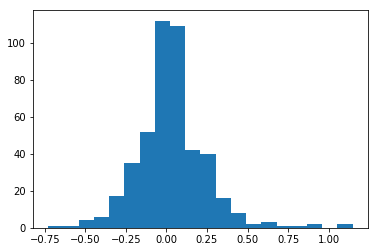

In [116]:
_ = plt.hist(res.dropna(), bins=20)

In [122]:
event_id_list = get_ngram_articles(article_df, ('research', 'review'))

size_prior_to_nan_removal = len(event_id_list)
returns = return_window["R_{}".format(20)].iloc[event_id_list].dropna()
num_removed = size_prior_to_nan_removal - returns.shape[0]

freq = returns.shape[0]/article_df.shape[0]
if freq >= 0.05:

    res_ = [
        np.mean(returns), 
        np.std(returns), 
        skew(returns.values), 
        kurtosis(returns.values),
        freq,
        num_removed,
        len(event_id_list)
    ]
    
print(res.mean())

0.03531044117376838


Alright, so the answers do not line up. I will have to go through the code to check on where the fault is. The most likely issue is probably in the getPrices class and then could be in how returns are calculated.

## Testing

In [143]:
samples = article_data.sample(10)

### Test GetPrices

In [145]:
GetPrices(samples, prices_df, 5, inplace=False).add_prices_to_frame()

,P_0,P_1,P_2,P_3,P_4,P_5
7,10.4500,11.2000,11.1000,10.7000,9.9500,10.5000
34,14.3500,14.8800,14.9200,14.7200,13.4000,13.7100
34,21.8700,22.5900,22.4300,22.3700,22.9700,23.6000
10,7.7900,7.7900,7.9900,7.9500,7.9500,7.9500
32,12.4600,12.3900,12.4000,12.1300,13.4000,13.2100
32,NaN,NaN,NaN,NaN,NaN,NaN
9,13.1400,12.3300,11.7300,11.5300,10.9700,11.4000
8,31.3400,32.3200,31.7800,31.6200,30.6100,29.9600
6,10.9700,10.2800,10.1600,9.8000,9.6100,9.3800
45,13.5511,13.6953,14.0316,14.0316,13.6953,13.6953


In [93]:
for ind, row in samples.iterrows():
    date = row.time
    ticker = row.ticker
    
    start_ind_loc = prices_df.index.tolist().index(date)
    end_ind_loc = start_ind_loc + 5

    try:
        p0 = prices_df[ticker].iloc[start_ind_loc]
        print("Does p0 match?", p0 == samples.loc[samples.ticker == ticker].P_0.values)
        p1 = prices_df[ticker].iloc[end_ind_loc]
        print("Does p1 match?", p1 == samples.loc[samples.ticker == ticker].P_5.values)

        ret = (p1 / p0) - 1
        print(ind, ticker, "  -  ", ret, "\n")
    except Exception as e:
        print(str(e))

Does p0 match? [False]
Does p1 match? [False]
37 ALEC   -   nan 

Does p0 match? [ True]
Does p1 match? [ True]
4 PACB   -   -0.005412719891745632 

Does p0 match? [ True]
Does p1 match? [ True]
1 ALLK   -   0.05304286052569274 

Does p0 match? [ True]
Does p1 match? [ True]
44 RGEN   -   0.06127450980392157 

Does p0 match? [False]
Does p1 match? [False]
24 MYOK   -   nan 

Does p0 match? [ True]
Does p1 match? [ True]
47 LIVN   -   -9.771350400633594e-05 

Does p0 match? [ True]
Does p1 match? [ True]
12 MGNX   -   -0.005036630036630019 

Does p0 match? [ True]
Does p1 match? [ True]
0 EOLS   -   0.008500000000000174 

Does p0 match? [ True]
Does p1 match? [ True]
2 ATNX   -   0.02869897959183665 

Does p0 match? [ True]
Does p1 match? [ True]
35 IMMU   -   0.2256482130343378 



In [91]:
compute_return_window(samples, prices_df, 5)

,R_1,R_2,R_3,R_4,R_5
37,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.002706,0.002706,0.000000,-0.005413
1,0.018233,0.103481,0.017049,0.012787,0.053043
44,0.024510,0.071078,0.046569,0.053922,0.061275
24,NaN,NaN,NaN,NaN,NaN
47,0.000000,-0.054817,-0.032636,-0.011237,-0.000098
12,0.014194,0.017857,0.001832,-0.028846,-0.005037
0,-0.006000,-0.042500,-0.061500,-0.012500,0.008500
2,0.010204,0.005102,0.023597,0.035714,0.028699
35,0.049755,0.040645,0.096006,0.131745,0.225648


### Deep look into GetPrices

I think it is keeping duplicate indices and that is causing the headache.